In [1]:
# Notebook settings

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Disable jupyter notebook autoscrolling

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Imports

import os
import subprocess
import warnings
warnings.simplefilter("ignore")
from cycler import cycler
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
linecolors = sns.color_palette('Set1')
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from mlens.ensemble import SuperLearner
import xgboost as xgb
import lightgbm as lgb

%reload_ext autoreload
%autoreload 2
import preprocessing
import modeling
import utils

plt.style.use('./stylelib/custom.mplstyle')

[MLENS] backend: threading


---

## 1 Data inspection and loading
### 1.1 Downsample training data
__Data size considerations__: The raw training data from kaggle has close to 200 million lines and takes 7 GB of memory. To keep EDA and evaluation steps of machine learning algorithms lightweight, a randomly sampled subset (0.1%) is used for EDA and model evaluation.

In [4]:
dir_data = './data'
from_scratch = False

# When from_scratch = True, generate randomly sampled subset
csv_train_raw = os.path.join(dir_data, 'train.csv')
csv_train = os.path.join(dir_data, 'train_sample.csv')
if from_scratch:
    nlines_raw, nlines_reduced = preprocessing.csv_randomized_downsamp(
        csv_in=csv_train_raw, csv_out=csv_train, fraction=0.001
    )

### 1.2 Load data into dataframe
#### (1) Field inspections
For efficiency concerns, we use shell commands instead of pandas operations.

In [5]:
# Quick check of training data fields by calling system shell command
!head -2 ./data/train_sample.csv

ip,app,device,os,channel,click_time,attributed_time,is_attributed
69196,12,1,19,424,2017-11-09 12:43:20,,0


In [6]:
# Quick check of test data fields by calling system shell command
!head -2 ./data/test.csv

click_id,ip,app,device,os,channel,click_time
0,5744,9,1,3,107,2017-11-10 04:00:00


**[Notes] Field selections** <br>
Field inspection tells us that training and testing data don't share the same fields. 
To prepare data for subsequent processing, we only preserve fields that are shared by both training and testing data. One exception is the `is_attributed` field in training data; It is the prediction target and thus needs to be preserved.

In [7]:
# Extract field names from training and testing data
dir_data = './data'
csv_train = os.path.join(dir_data, 'train_sample.csv')
fields_train = preprocessing.csv_list_fields(csv_in=csv_train)
csv_test = os.path.join(dir_data, 'test.csv')
fields_test = preprocessing.csv_list_fields(csv_in=csv_test)

# Extract fields shared by both training and testing data
fields_keep = list(set(fields_train) & (set(fields_test)))
print('Data fields shared by both training and testing data:\n', fields_keep)

Data fields shared by both training and testing data:
 ['os', 'device', 'channel', 'app', 'click_time', 'ip']


#### (2) Load into dataframe

In [8]:
# Load randomly sampled data subset into pandas dataframe,
# and sort by click time (and reset index)
df = pd.read_csv(
    csv_train, usecols=fields_keep + ['is_attributed'],
    parse_dates=['click_time']
).sort_values(by='click_time').reset_index(drop=True)

# Convert click time from UTC to local time
df['click_time'] = (
    pd.DatetimeIndex(df['click_time']).tz_localize('utc')
    .tz_convert('Asia/Shanghai')
)

In [9]:
# Check cardinality of the raw features
df_cardinality = utils.df_check_cardinality(df)
df_cardinality

,ip,app,device,os,channel,click_time,is_attributed
n_unique,46005.000000,186.000000,148.000000,143.000000,164.000000,125421.0000,2.000000
n_unique (%),24.880613,0.100593,0.080042,0.077338,0.088695,67.8307,0.001082


__IMPORTANT__: The raw features are all categorical and are of ___very high cardinality___. Simpler techniques such as one hot encoding is not applicable and feature engineering will require major efforts.

---
## 2. Exploratory data analysis
### 2.1 Examine class proportion

In [10]:
# Inspect data size
nclick_total =len(df)
percentage_pos = (df['is_attributed'].sum()) / nclick_total * 100
print('Percentage of positive target = {:.3f}%'.format(percentage_pos))

Percentage of positive target = 0.239%


**[CAUTION] Class imbalance**<br>
Given that only __<span class="mark">~0.2%</span>__ of the records has positive target values (`df['is_attributed'] == 1`), we have **an extreme case of class imbalance** at hand.

### 2.2 Convert datetime variable to usable form
Among the datetime fields such as month, day, and hour-of-the-day, we only keep hour-of-day and name it as `click_hour` for subsequent processing.

In [11]:
# 1. Extract hour of the day
df['click_hour'] = df['click_time'].dt.hour

# 2. Drop raw `click_time`
df.drop(columns=['click_time'], inplace=True)

In [12]:
df.head(3)

,ip,app,device,os,channel,is_attributed,click_hour
0,126483,12,1,19,265,0,0
1,67188,14,1,37,379,0,0
2,85625,12,1,19,140,0,0


### 2.3 Train-test split, and set aside testing data

In [13]:
# Split the original dataframe into in-sample training and testing sets
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

# Double check class ratios after train-test split
print(
    'Training data (pos%):',
    100 * df_train['is_attributed'].sum() / len(df_train)
)
print(
    'Testing data (pos%):',
    100 * df_test['is_attributed'].sum() / len(df_test)
)

Training data (pos%): 0.23332715248161195
Testing data (pos%): 0.25058138486776876


### 2.4 Inspect variable distributions of training data

In [14]:
# Count the amount of unique values
df_counts = pd.DataFrame()
df_counts['n_unique'] = df_train.nunique()
df_counts['n_unique (%)'] = 100 * df_counts['n_unique'] / len(df_train)
df_counts.T

,ip,app,device,os,channel,is_attributed,click_hour
n_unique,39415.000000,172.000000,113.000000,131.000000,161.00000,2.000000,24.000000
n_unique (%),30.452284,0.132888,0.087305,0.101211,0.12439,0.001545,0.018543


**[TAKE AWAY]**<br>
* Without exception, the total number of unique values for each of these variables is markedly smaller than the total number of clicks. This indicates that many-to-one mapping is typical between clicks and attributes such as `ip`, `app`, and `device`. This is reasonable given that a single user can generate multiple clicks.
* The categorical features at hand are of very high cardinality. Feature engineering is going to be critical in preparing the data for machine learning.

### 2.5 Apply target-guided encoding to categorical features

In [15]:
feature_list = [x for x in df_train.columns if x != 'is_attributed']
impute_rare = True
if impute_rare:
    df_train, df_test = preprocessing.df_rarelabel_imputer(
        df_train, df_test, cols=feature_list, thresh_percentage=0.05
    )
df_train, df_test = preprocessing.df_label2num_encoding(
    df_train, df_test, cols=feature_list
)

### 2.6 Visualize features' correlation coefficients

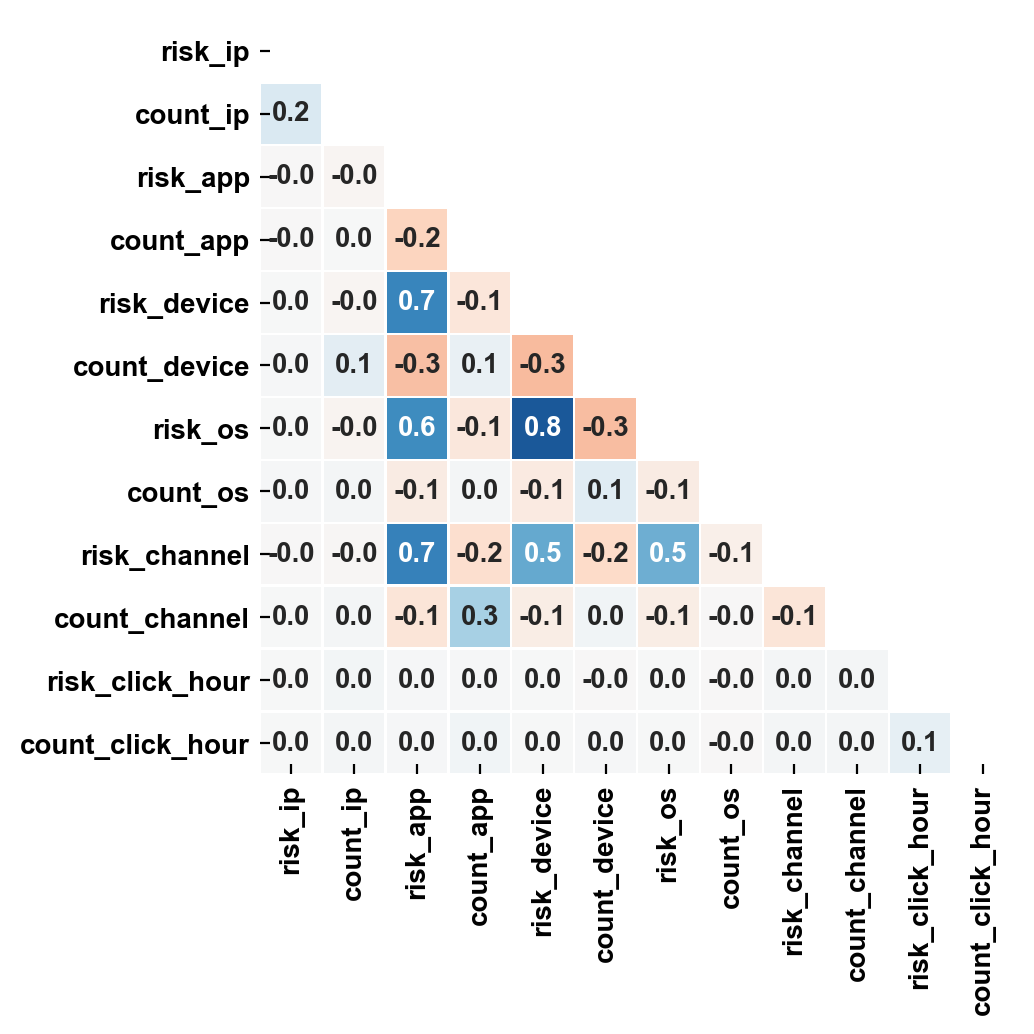

In [16]:
# Plot Pearson's correlation coefficients
utils.plot_corrmat(df_train, figsize=(5, 5))

### 2.7 Check dataframes after encoding

Note that mapping used for encoding is generated with training data and then propagated to testing data. 
Because there are non-overlap variables between training and testing data, and encoded testing data are going to have missing values. Let's have a look:

In [17]:
# Check presence of missing value after encoding
df_nulls = pd.DataFrame()
df_nulls['nan_train(%)'] = 100 * (df_train.isnull().sum() / len(df_train))
df_nulls['nan_test(%)'] = 100 * (df_test.isnull().sum() / len(df_test))
df_nulls.T

,is_attributed,risk_ip,count_ip,risk_app,count_app,risk_device,count_device,risk_os,count_os,risk_channel,count_channel,risk_click_hour,count_click_hour
nan_train(%),0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
nan_test(%),0.0,13.859494,13.859494,0.032449,0.032449,0.068504,0.068504,0.030647,0.030647,0.007211,0.007211,0.0,0.0


---
## 3. Machine learning
### 3.1 Data preparation

In [18]:
target_col = 'is_attributed'
feature_cols = [x for x in df_train.columns if x != target_col]
print('List of features being used:\n', feature_cols)

X_train, y_train = preprocessing.df_to_Xy(
    df_train, target_col=target_col, feature_cols=feature_cols
)
X_test, y_test = preprocessing.df_to_Xy(
    df_test, target_col=target_col, feature_cols=feature_cols
)

List of features being used:
 ['risk_ip', 'count_ip', 'risk_app', 'count_app', 'risk_device', 'count_device', 'risk_os', 'count_os', 'risk_channel', 'count_channel', 'risk_click_hour', 'count_click_hour']


### 3.2 Model evaluation
List of models to be evaluated:
* Logistic regression
* Random forest
* Stack ensemble
* Extreme gradient boosting
* Light gradient boosting

In [19]:
# Initialize book keeping for ROC curve, precision-recall curve,
# confusion matrixes, and feature importance ranking
model_list = ([
    'LogisticRegression', 'RandomForest', 'StackEnsemble',
    'XGBoost', 'LightGBM'
])
roc_val = dict.fromkeys(model_list)
prec_recall_val = dict.fromkeys(model_list)
confmat = dict.fromkeys(model_list)
ft_importance = dict.fromkeys(model_list)

#### (1) Benchmark: Logistic regression

logisticregression
fit runtime = 3.15 s


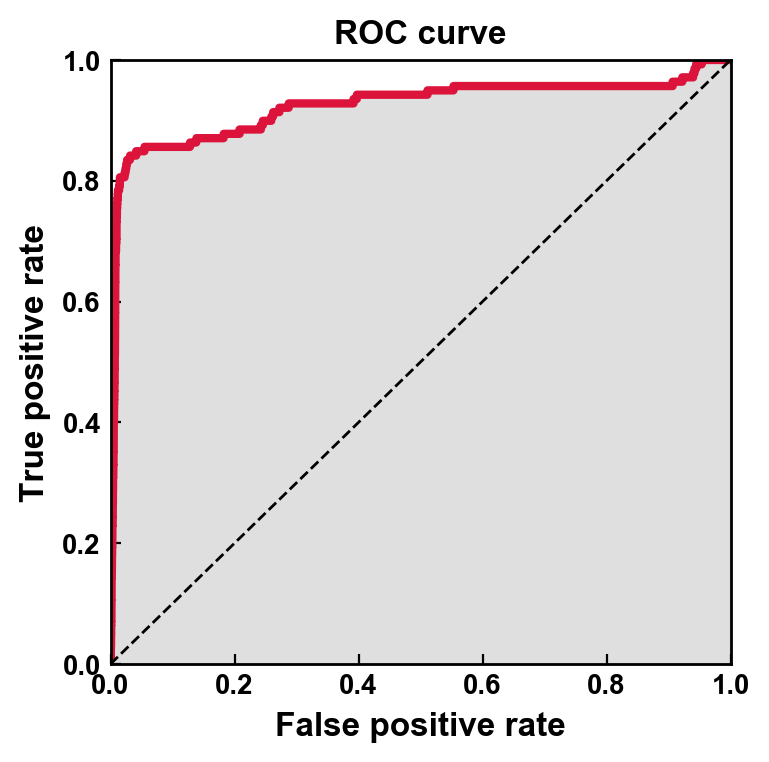

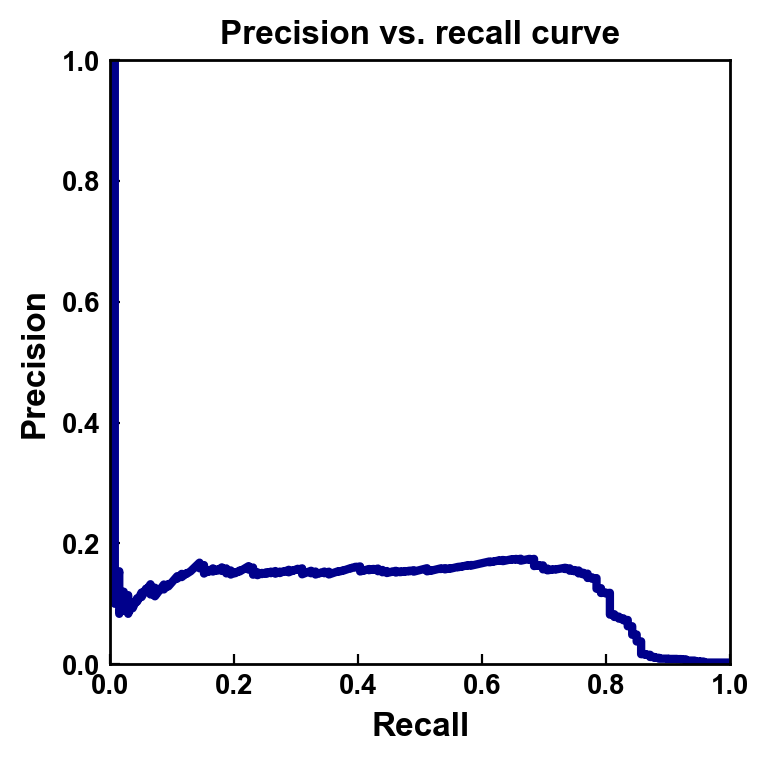

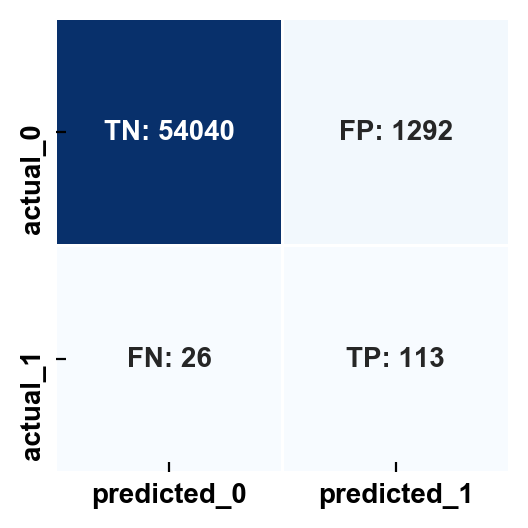

,model,auc_train,auc_cv_std,auc_test
0,LogisticRegression,0.940,0.007,0.895


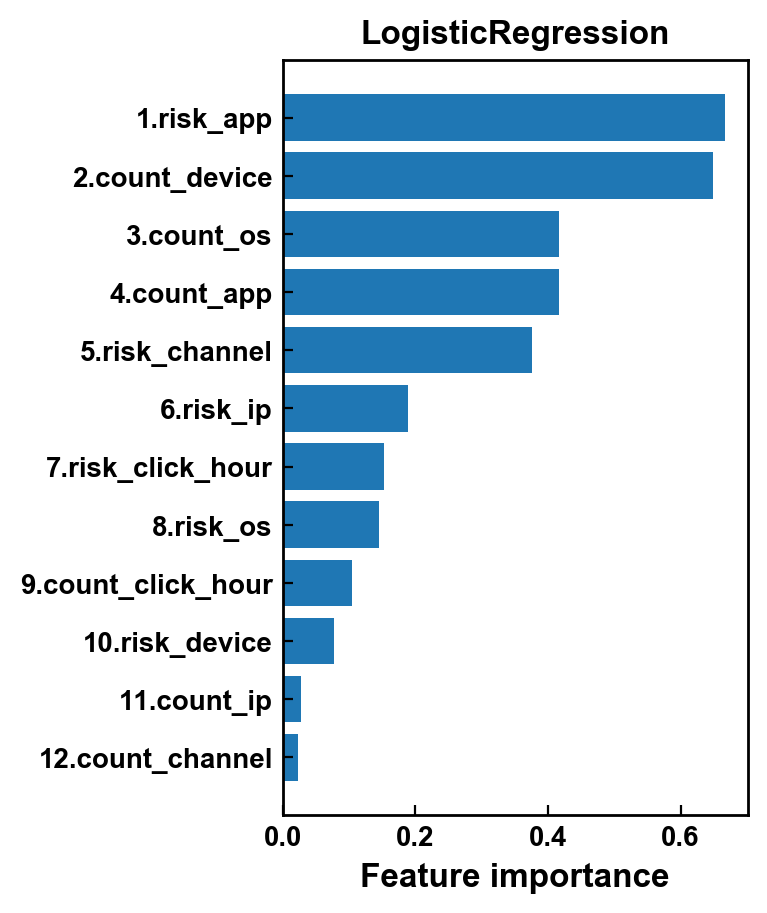

In [20]:
model_name = 'LogisticRegression'

estimator = LogisticRegression(class_weight='balanced')
model = modeling.Classifier(gridsearch=False)
model.fit(estimator, X_train, y_train, cv=5)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test) 
test_score = roc_auc_score(y_test, y_pred)

# plot ROC curve
roc_val[model_name] = utils.plot_roc_curve(
    y_test, y_pred_proba, figsize=(4, 4), c='crimson', lw=3
)
# plot precision_vs_recall curve
prec_recall_val[model_name] = utils.plot_precision_vs_recall(
    y_test, y_pred_proba, figsize=(4, 4), c='darkblue', lw=3
)
# plot confusion matrix
confmat[model_name] = utils.plot_confusion_matrix(
    y_test, y_pred, figsize=(3, 3)
)

# Score keeping
df_scores = utils.ml_performance_summary(
    model.train_score, test_score, model_name=model_name
)
display(df_scores)

ft_importance[model_name] = utils.plot_feature_importance(
    model, feature_list=feature_cols, model_name=model_name, figsize=(3, 5)
);

#### (2) Bagging ensemble: Random forest

randomforestclassifier
fit runtime = 10.14 s


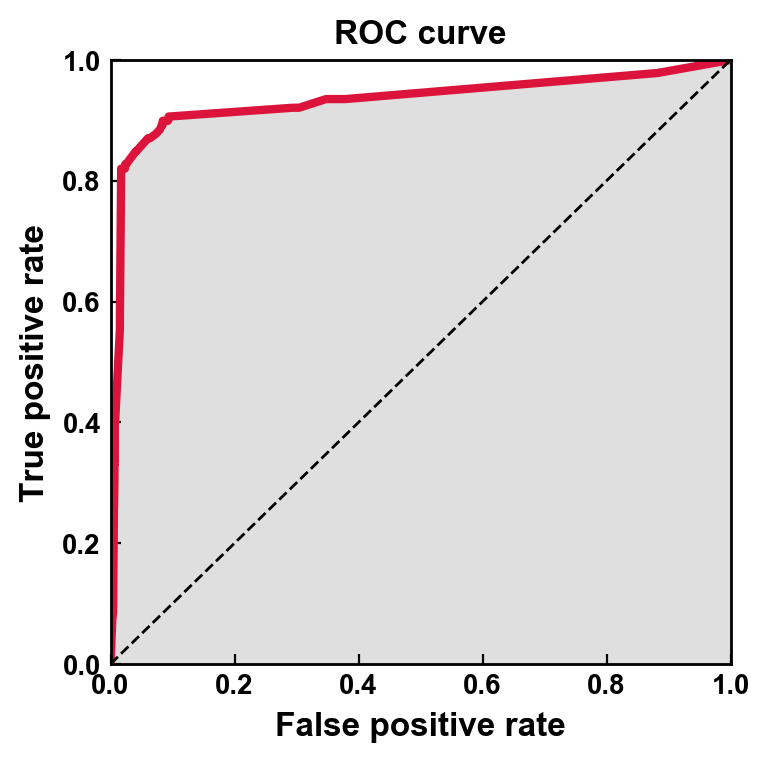

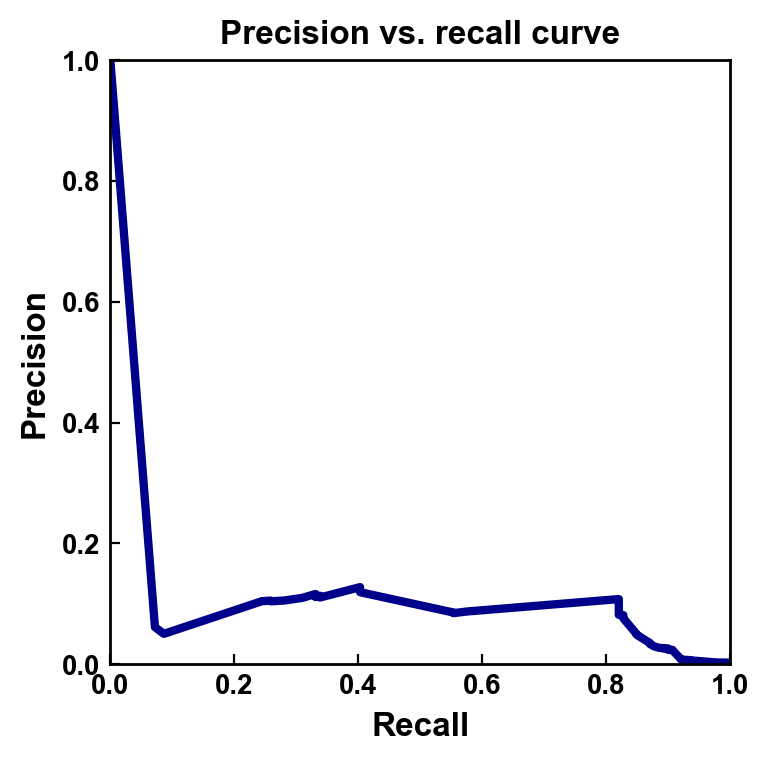

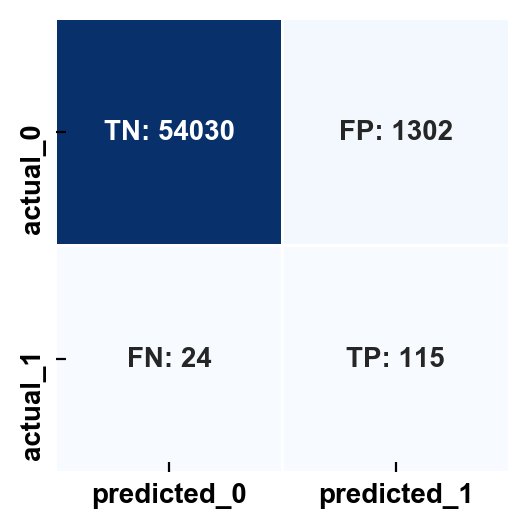

,model,auc_train,auc_cv_std,auc_test
0,LogisticRegression,0.940,0.007,0.895
1,RandomForest,0.921,0.006,0.902


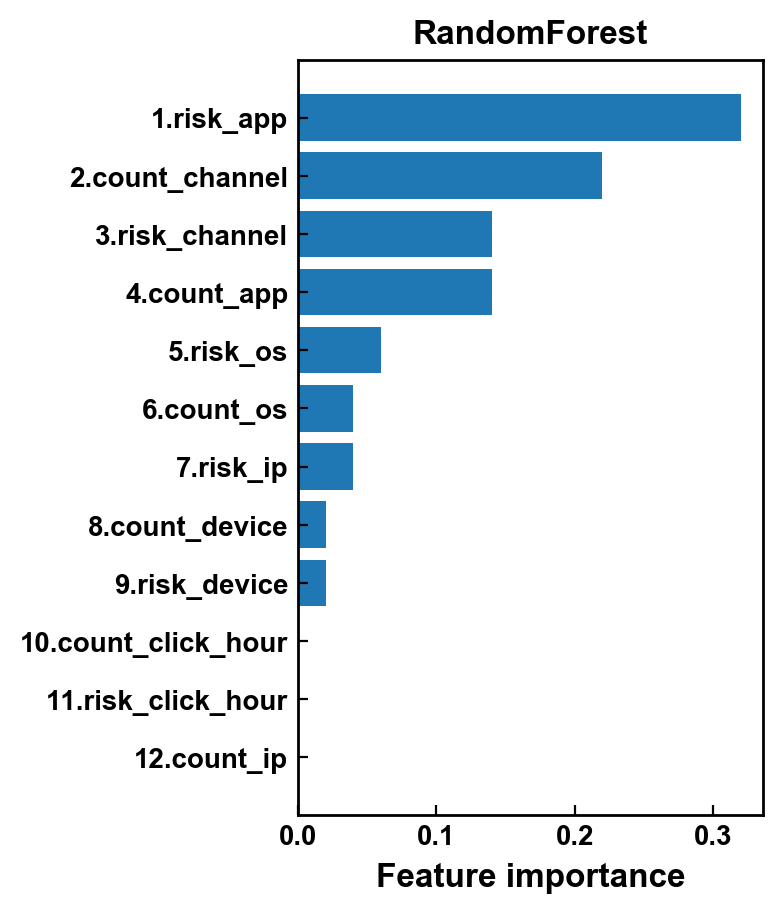

In [21]:
model_name = 'RandomForest'

estimator = RandomForestClassifier(
    class_weight='balanced', max_depth=1, n_estimators=50,
    random_state=42
)
model = modeling.Classifier(gridsearch=False)
model.fit(estimator, X_train, y_train, cv=5)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
test_score = roc_auc_score(y_test, y_pred)

# ROC curve demo
roc_val[model_name] = utils.plot_roc_curve(
    y_test, y_pred_proba, figsize=(4, 4), c='crimson', lw=3
)
# plot precision_vs_recall curve
prec_recall_val[model_name] = utils.plot_precision_vs_recall(
    y_test, y_pred_proba, figsize=(4, 4), c='darkblue', lw=3
)
# plot confusion matrix
confmat[model_name] = utils.plot_confusion_matrix(
    y_test, y_pred, figsize=(3, 3)
)

# Score keeping
df_scores = df_scores.append(utils.ml_performance_summary(
    model.train_score, test_score, model_name=model_name
)).reset_index(drop=True)
display(df_scores)

ft_importance[model_name] = utils.plot_feature_importance(
    model, feature_list=feature_cols, model_name=model_name, figsize=(3, 5)
);

#### (3) Stacking ensemble: Random forest + logistic regression
Two layer stack:
* Base learners: Random forest and Naive Bayes
* Meta learner: logistic regression

superlearner
fit runtime = 3.16 s
0.9022197713377811


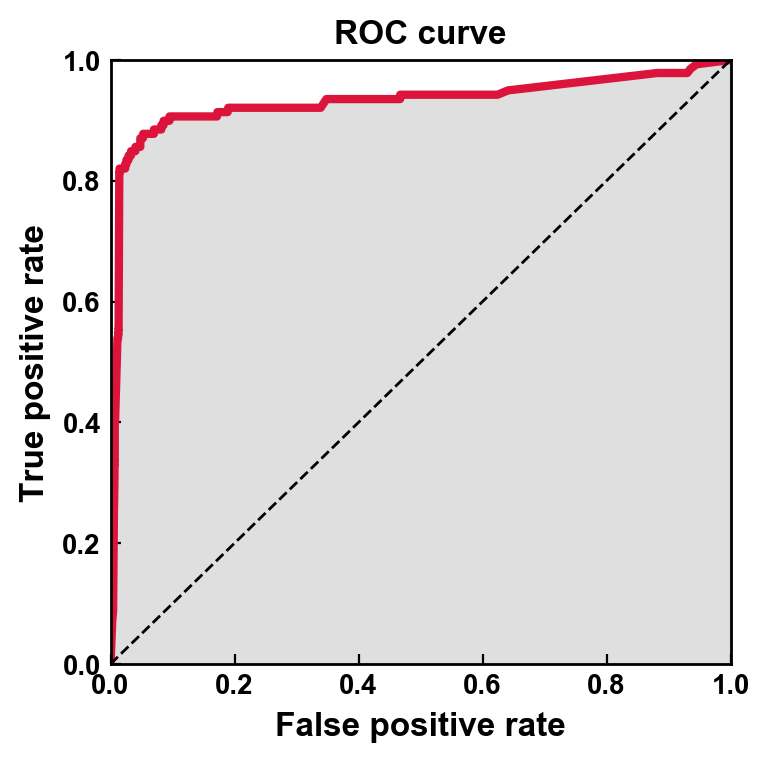

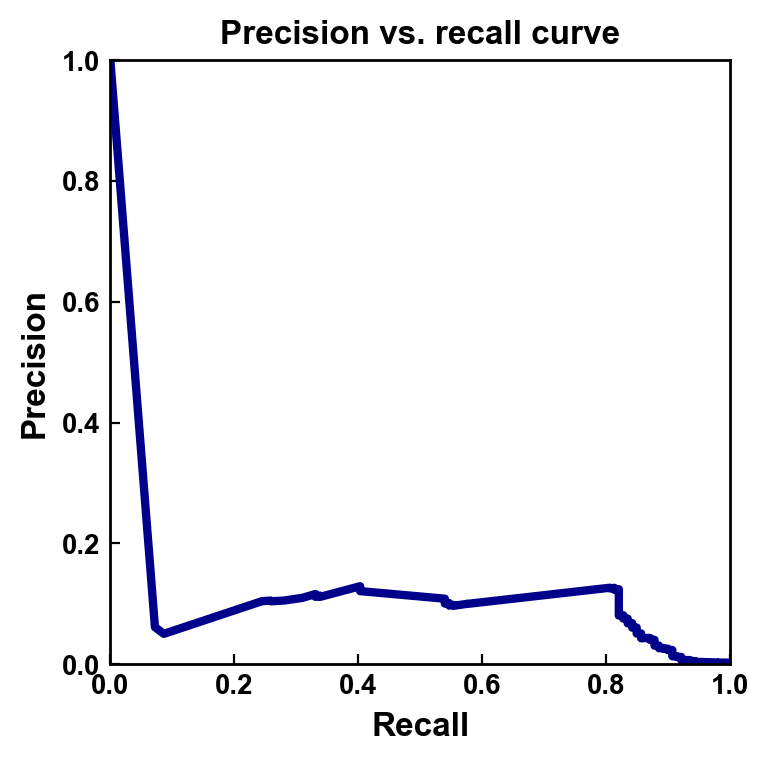

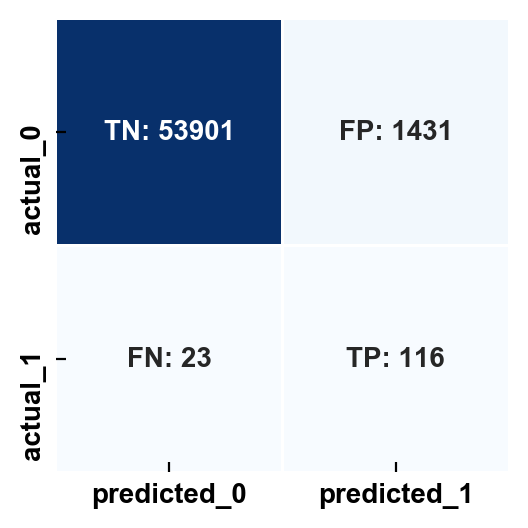

,model,auc_train,auc_cv_std,auc_test
0,LogisticRegression,0.940,0.007,0.895
1,RandomForest,0.921,0.006,0.902
2,StackEnsemble,0.902,nan,0.904


In [22]:
model_name = 'StackEnsemble'
estimator = SuperLearner(random_state=42, verbose=0)
import copy

def stacking_wrapper(estimator, proba=True):
    estimator.add([
        RandomForestClassifier(
            class_weight='balanced', max_depth=1, n_estimators=50,
            random_state=42
        ), GaussianNB()
    ], proba=proba);
    estimator.add_meta(
        LogisticRegression(class_weight='balanced'), proba=proba
    );
    
    model = modeling.Classifier(gridsearch=False)
    model.fit(estimator, X_train, y_train, cv=None)
    print(model.train_score)
    model_out = copy.deepcopy(model)
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba[:, 1] >= 0.5).astype(float)
    return (y_pred, y_pred_proba, model_out)
    

# y_pred = wrapper(estimator, proba=False)
y_pred, y_pred_proba, model = stacking_wrapper(estimator, proba=True)
test_score = roc_auc_score(y_test, y_pred)

# ROC curve demo
roc_val[model_name] = utils.plot_roc_curve(
    y_test, y_pred_proba, figsize=(4, 4), c='crimson', lw=3
)
# plot precision_vs_recall curve
prec_recall_val[model_name] = utils.plot_precision_vs_recall(
    y_test, y_pred_proba, figsize=(4, 4), c='darkblue', lw=3
)
# plot confusion matrix
confmat[model_name] = utils.plot_confusion_matrix(
    y_test, y_pred, figsize=(3, 3)
)

# Score keeping
df_scores = df_scores.append(utils.ml_performance_summary(
    model.train_score, test_score, model_name=model_name
)).reset_index(drop=True)
display(df_scores)

# ft_importance[model_name] = utils.plot_feature_importance(
#     model, feature_list=feature_cols, model_name=model_name, figsize=(3, 5)
# );

#### (4) Boosting ensemble: extreme gradient boosting with tree base learner

xgbclassifier
fit runtime = 12.74 s


/Users/shandou/anaconda3/envs/mlnd_capstone/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


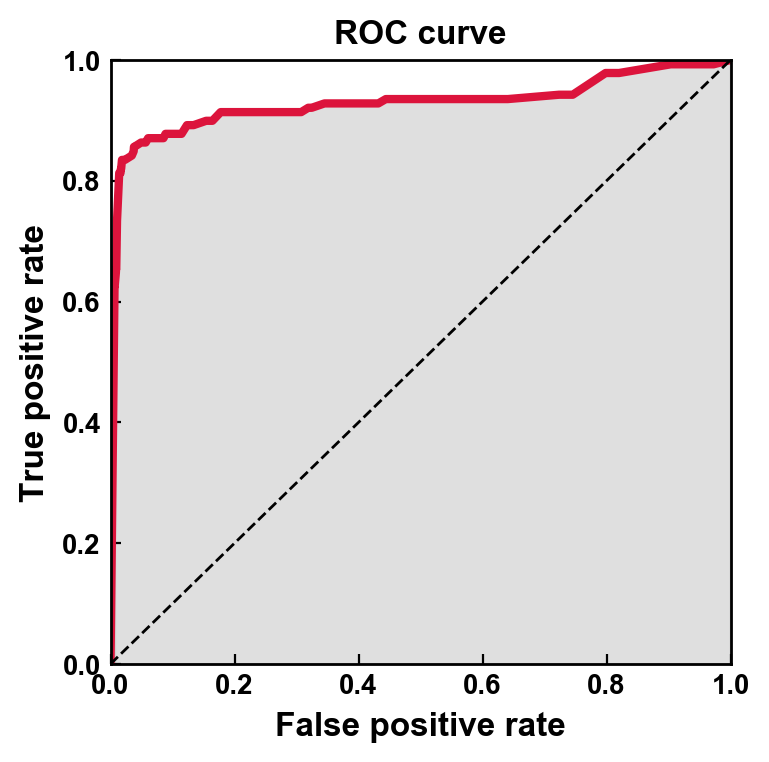

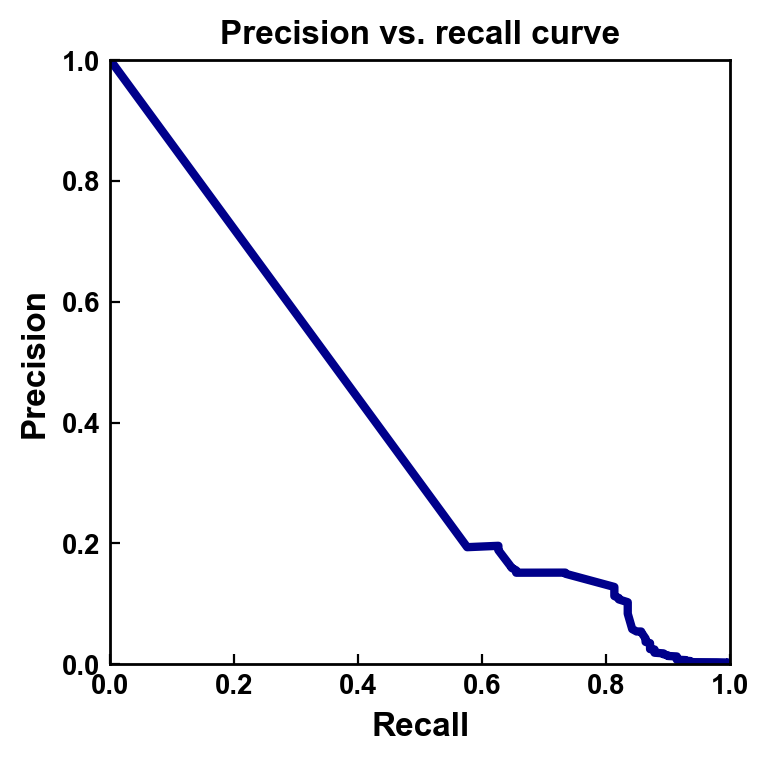

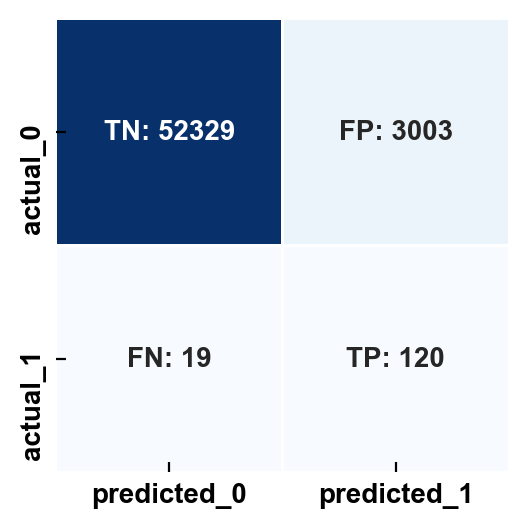

,model,auc_train,auc_cv_std,auc_test
0,LogisticRegression,0.940,0.007,0.895
1,RandomForest,0.921,0.006,0.902
2,StackEnsemble,0.902,nan,0.904
3,XGBoost,0.969,0.006,0.905


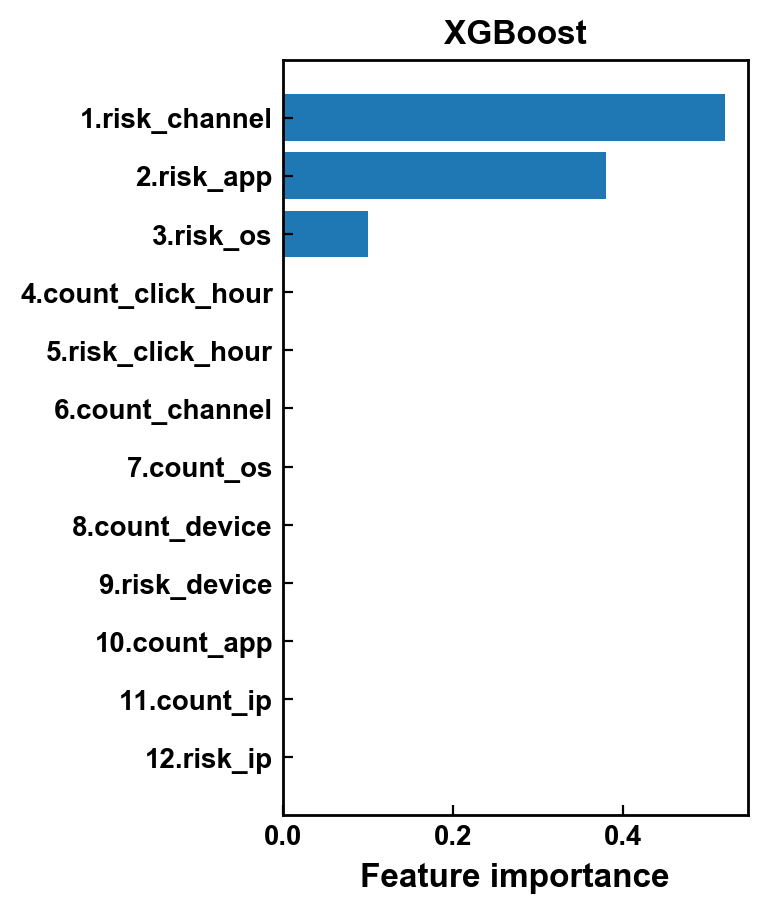

In [23]:
model_name = 'XGBoost'

# xgb scikit-learn API
estimator = xgb.XGBClassifier(
    max_depth=1, n_estimators=50, random_state=42
)
model = modeling.Classifier(gridsearch=False)
model.fit(estimator, X_train, y_train, cv=5)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
test_score = roc_auc_score(y_test, y_pred)

# ROC curve demo
roc_val[model_name] = utils.plot_roc_curve(
    y_test, y_pred_proba, figsize=(4, 4), c='crimson', lw=3
)
# plot precision_vs_recall curve
prec_recall_val[model_name] = utils.plot_precision_vs_recall(
    y_test, y_pred_proba, figsize=(4, 4), c='darkblue', lw=3
)
# plot confusion matrix
confmat[model_name] = utils.plot_confusion_matrix(
    y_test, y_pred, figsize=(3, 3)
)

# Score keeping
df_scores = df_scores.append(utils.ml_performance_summary(
    model.train_score, test_score, model_name=model_name
)).reset_index(drop=True)
display(df_scores)

ft_importance[model_name] = utils.plot_feature_importance(
    model, feature_list=feature_cols, model_name=model_name, figsize=(3, 5)
);

#### (5) Boosting ensemble: Light gradient boosting

lgbmclassifier
fit runtime = 4.62 s


/Users/shandou/anaconda3/envs/mlnd_capstone/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


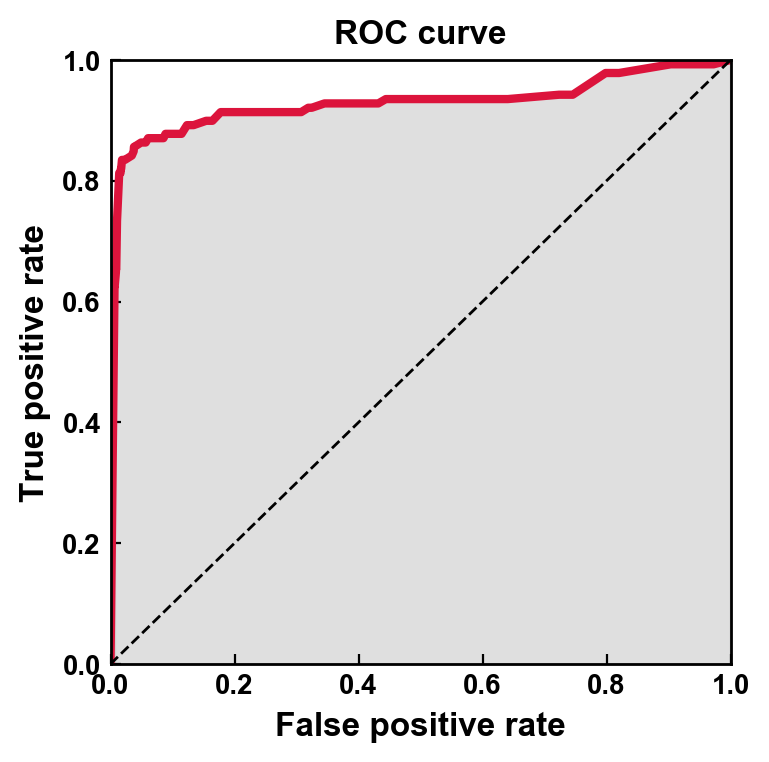

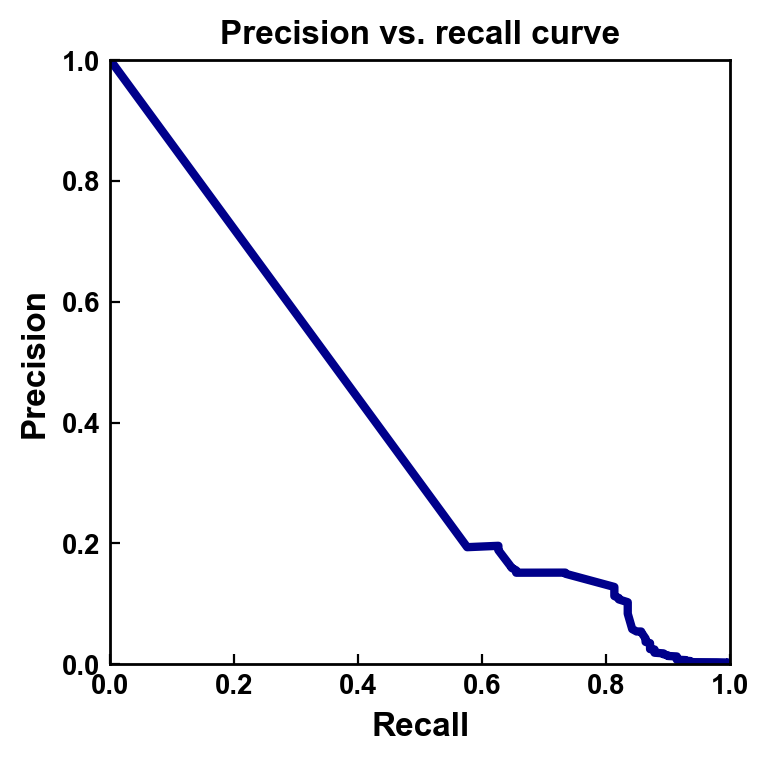

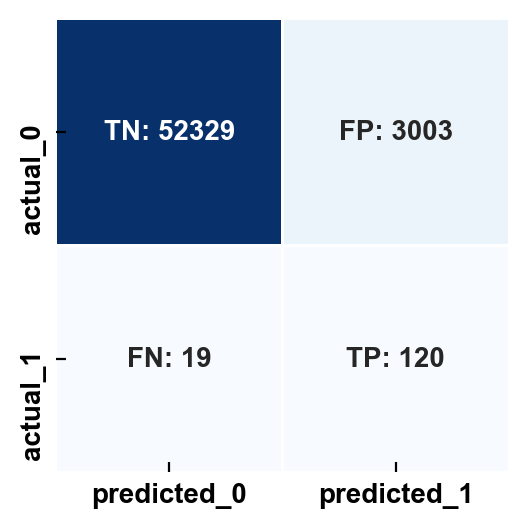

,model,auc_train,auc_cv_std,auc_test
0,LogisticRegression,0.940,0.007,0.895
1,RandomForest,0.921,0.006,0.902
2,StackEnsemble,0.902,nan,0.904
3,XGBoost,0.969,0.006,0.905
4,LightGBM,0.969,0.006,0.905


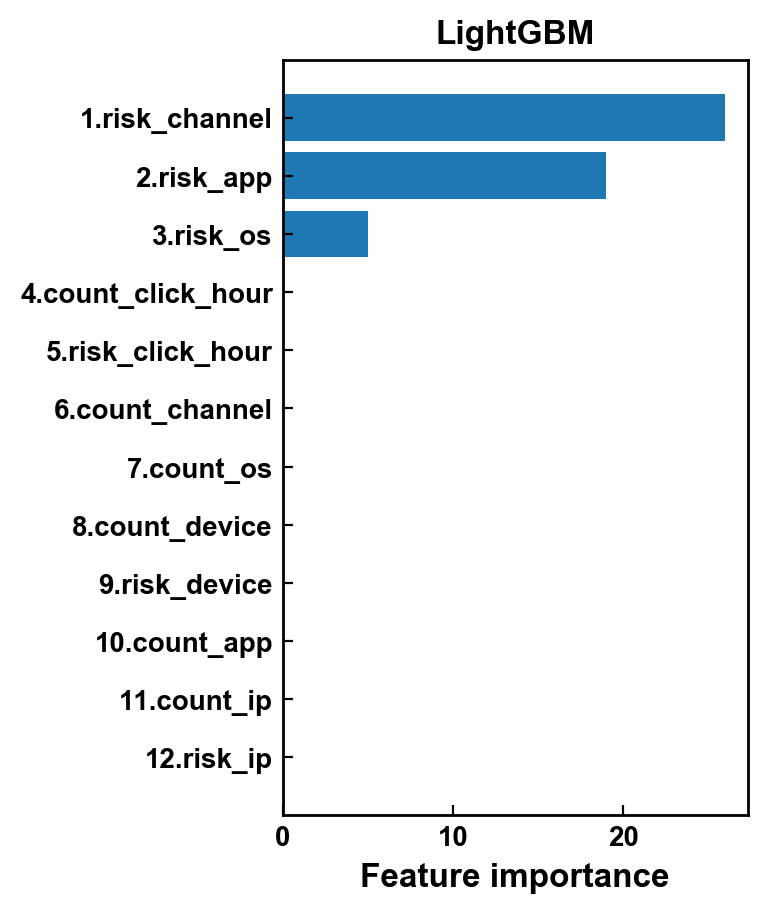

In [24]:
model_name = 'LightGBM'

# lightgbm scikit-learn API
estimator = lgb.LGBMClassifier(
    max_depth=1, n_estimators=50, random_state=42
)
model = modeling.Classifier(gridsearch=False)
model.fit(estimator, X_train, y_train, cv=5)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
test_score = roc_auc_score(y_test, y_pred)

# ROC curve demo
roc_val[model_name] = utils.plot_roc_curve(
    y_test, y_pred_proba, figsize=(4, 4), c='crimson', lw=3
)
# plot precision_vs_recall curve
prec_recall_val[model_name] = utils.plot_precision_vs_recall(
    y_test, y_pred_proba, figsize=(4, 4), c='darkblue', lw=3
)
# plot confusion matrix
confmat[model_name] = utils.plot_confusion_matrix(
    y_test, y_pred, figsize=(3, 3)
)

# Score keeping
df_scores = df_scores.append(utils.ml_performance_summary(
    model.train_score, test_score, model_name=model_name
)).reset_index(drop=True)
display(df_scores)


ft_importance[model_name] = utils.plot_feature_importance(
    model, feature_list=feature_cols, model_name=model_name, figsize=(3, 5)
);

### 3.3 Comparisons of model performances

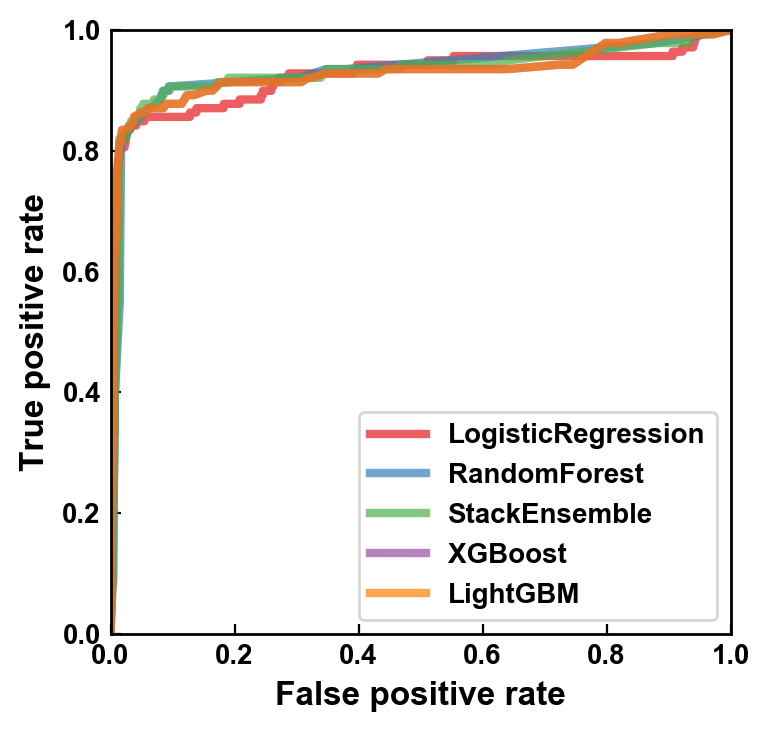

In [25]:
# ROC curve comparison
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_prop_cycle(cycler('color', linecolors))
for model in roc_val:
    ax.plot(
        roc_val[model][0], roc_val[model][1], lw=3, label=model, alpha=0.7
    )
ax.set(
    xlim=(0, 1), ylim=(0, 1),
    xlabel='False positive rate', ylabel='True positive rate'
)
ax.legend(loc='lower right')
plt.show();

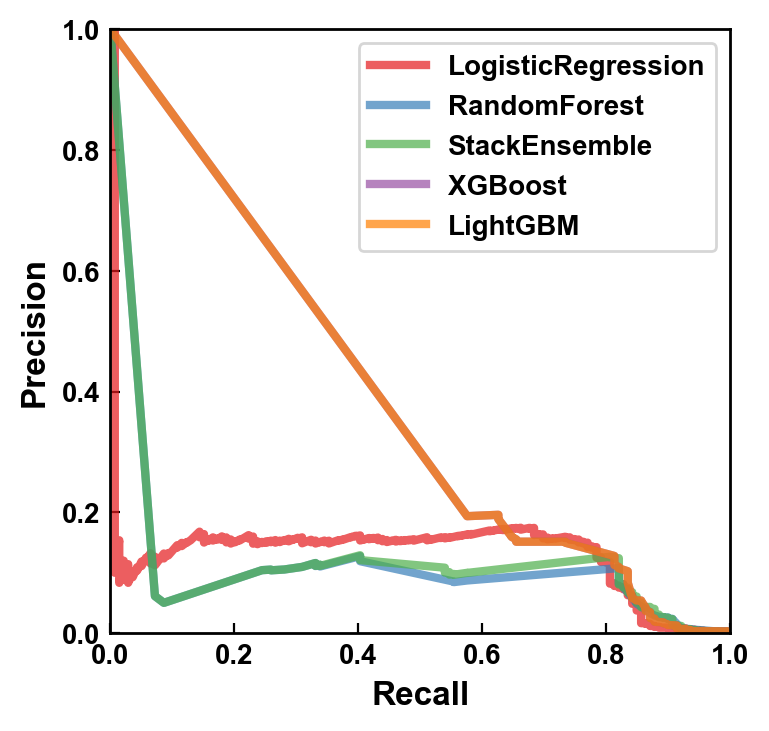

In [26]:
# Precision-recall curve comparison
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_prop_cycle(cycler('color', linecolors))
for model in roc_val:
    ax.plot(
        prec_recall_val[model][0], prec_recall_val[model][1], lw=3,
        label=model, alpha=0.7
    )
ax.set(
    xlim=(0, 1), ylim=(0, 1), xlabel='Recall', ylabel='Precision'
)
ax.legend(loc='upper right')
plt.show();

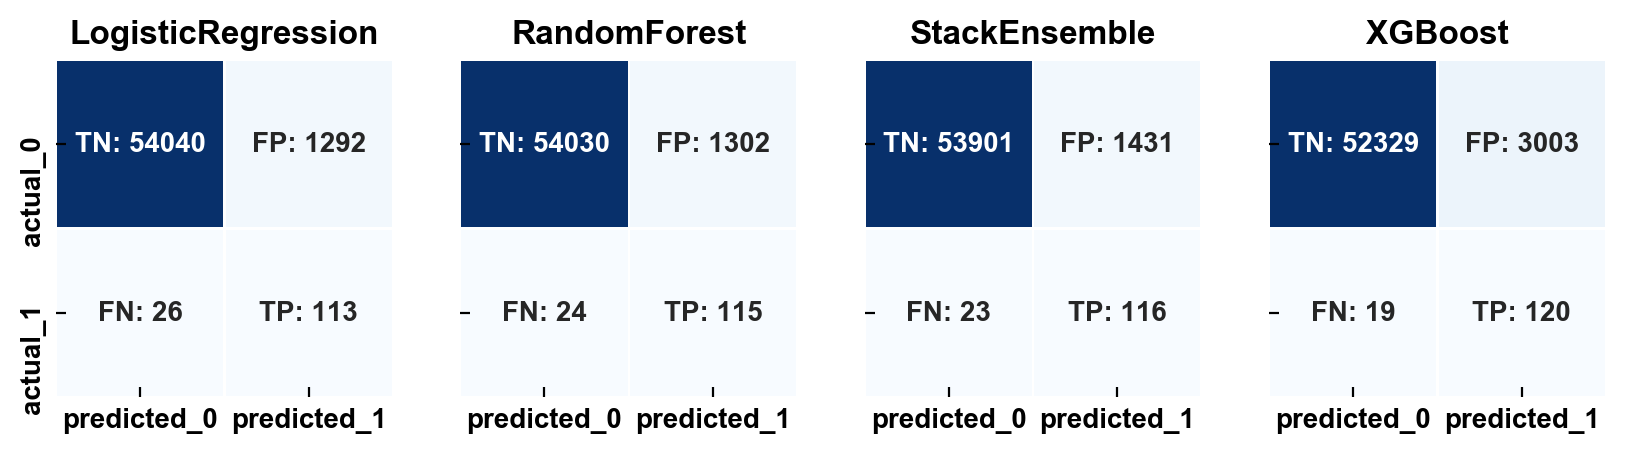

In [28]:
# Confusion matrix comparison
fig, ax = plt.subplots(
    nrows=1, ncols=4, figsize=(10, 3), sharex=True, sharey=True
)
for model, axi in zip(confmat, ax.flatten()):
    cm = confmat[model].values
    labels = np.array([
        ['TN: {:d}'.format(cm[0][0]), 'FP: {:d}'.format(cm[0][1])],
        ['FN: {:d}'.format(cm[1][0]), 'TP: {:d}'.format(cm[1][1])]
    ])
    sns.heatmap(
        confmat[model], annot=labels, cmap='Blues', square=True,
        linewidths=.5, cbar=False, fmt='', ax=axi
    )
    axi.set(title=model)
plt.show();

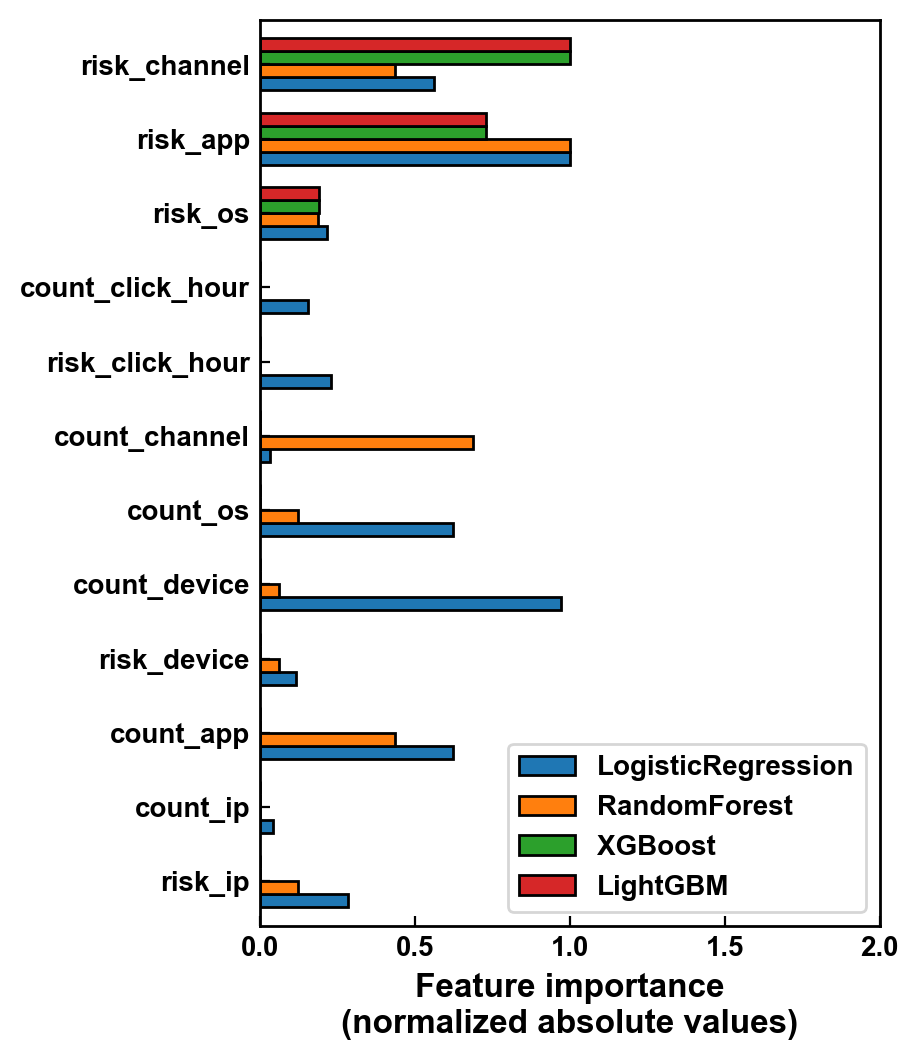

In [64]:
# Feature importance ranking comparison
model_list_ftimportance = [x for x in model_list if x is not 'StackEnsemble']
df_ft_importance = pd.DataFrame(
    index=ft_importance[model][0], columns=model_list_ftimportance
)
for model in model_list_ftimportance:
    df_ft_importance[model] = pd.DataFrame(
        index=ft_importance[model][0],
        data=abs(ft_importance[model][1])
    )
    df_ft_importance[model] = (
        df_ft_importance[model] / np.max(abs(df_ft_importance[model]))
    )

fig, ax = plt.subplots(figsize=(4, 6))
df_ft_importance.plot(kind='barh', ax=ax, width=0.7, edgecolor='k')
ax.set(xlim=(0, 2), xlabel='Feature importance\n(normalized absolute values)')
ax.legend(loc='lower right')
plt.show();